# 手动推导BS公式

# 以20250414中午黄金价格为例
## Refs
[上期所：黄金期权](https://www.shfe.com.cn/products/option/ferrousandpreciousmetal/au_o/) 
[上期所：期权业务指南](https://www.shfe.com.cn/products/option/energyandchemical/br_o/manual_guid/202307/P020240320712593643783.pdf)   
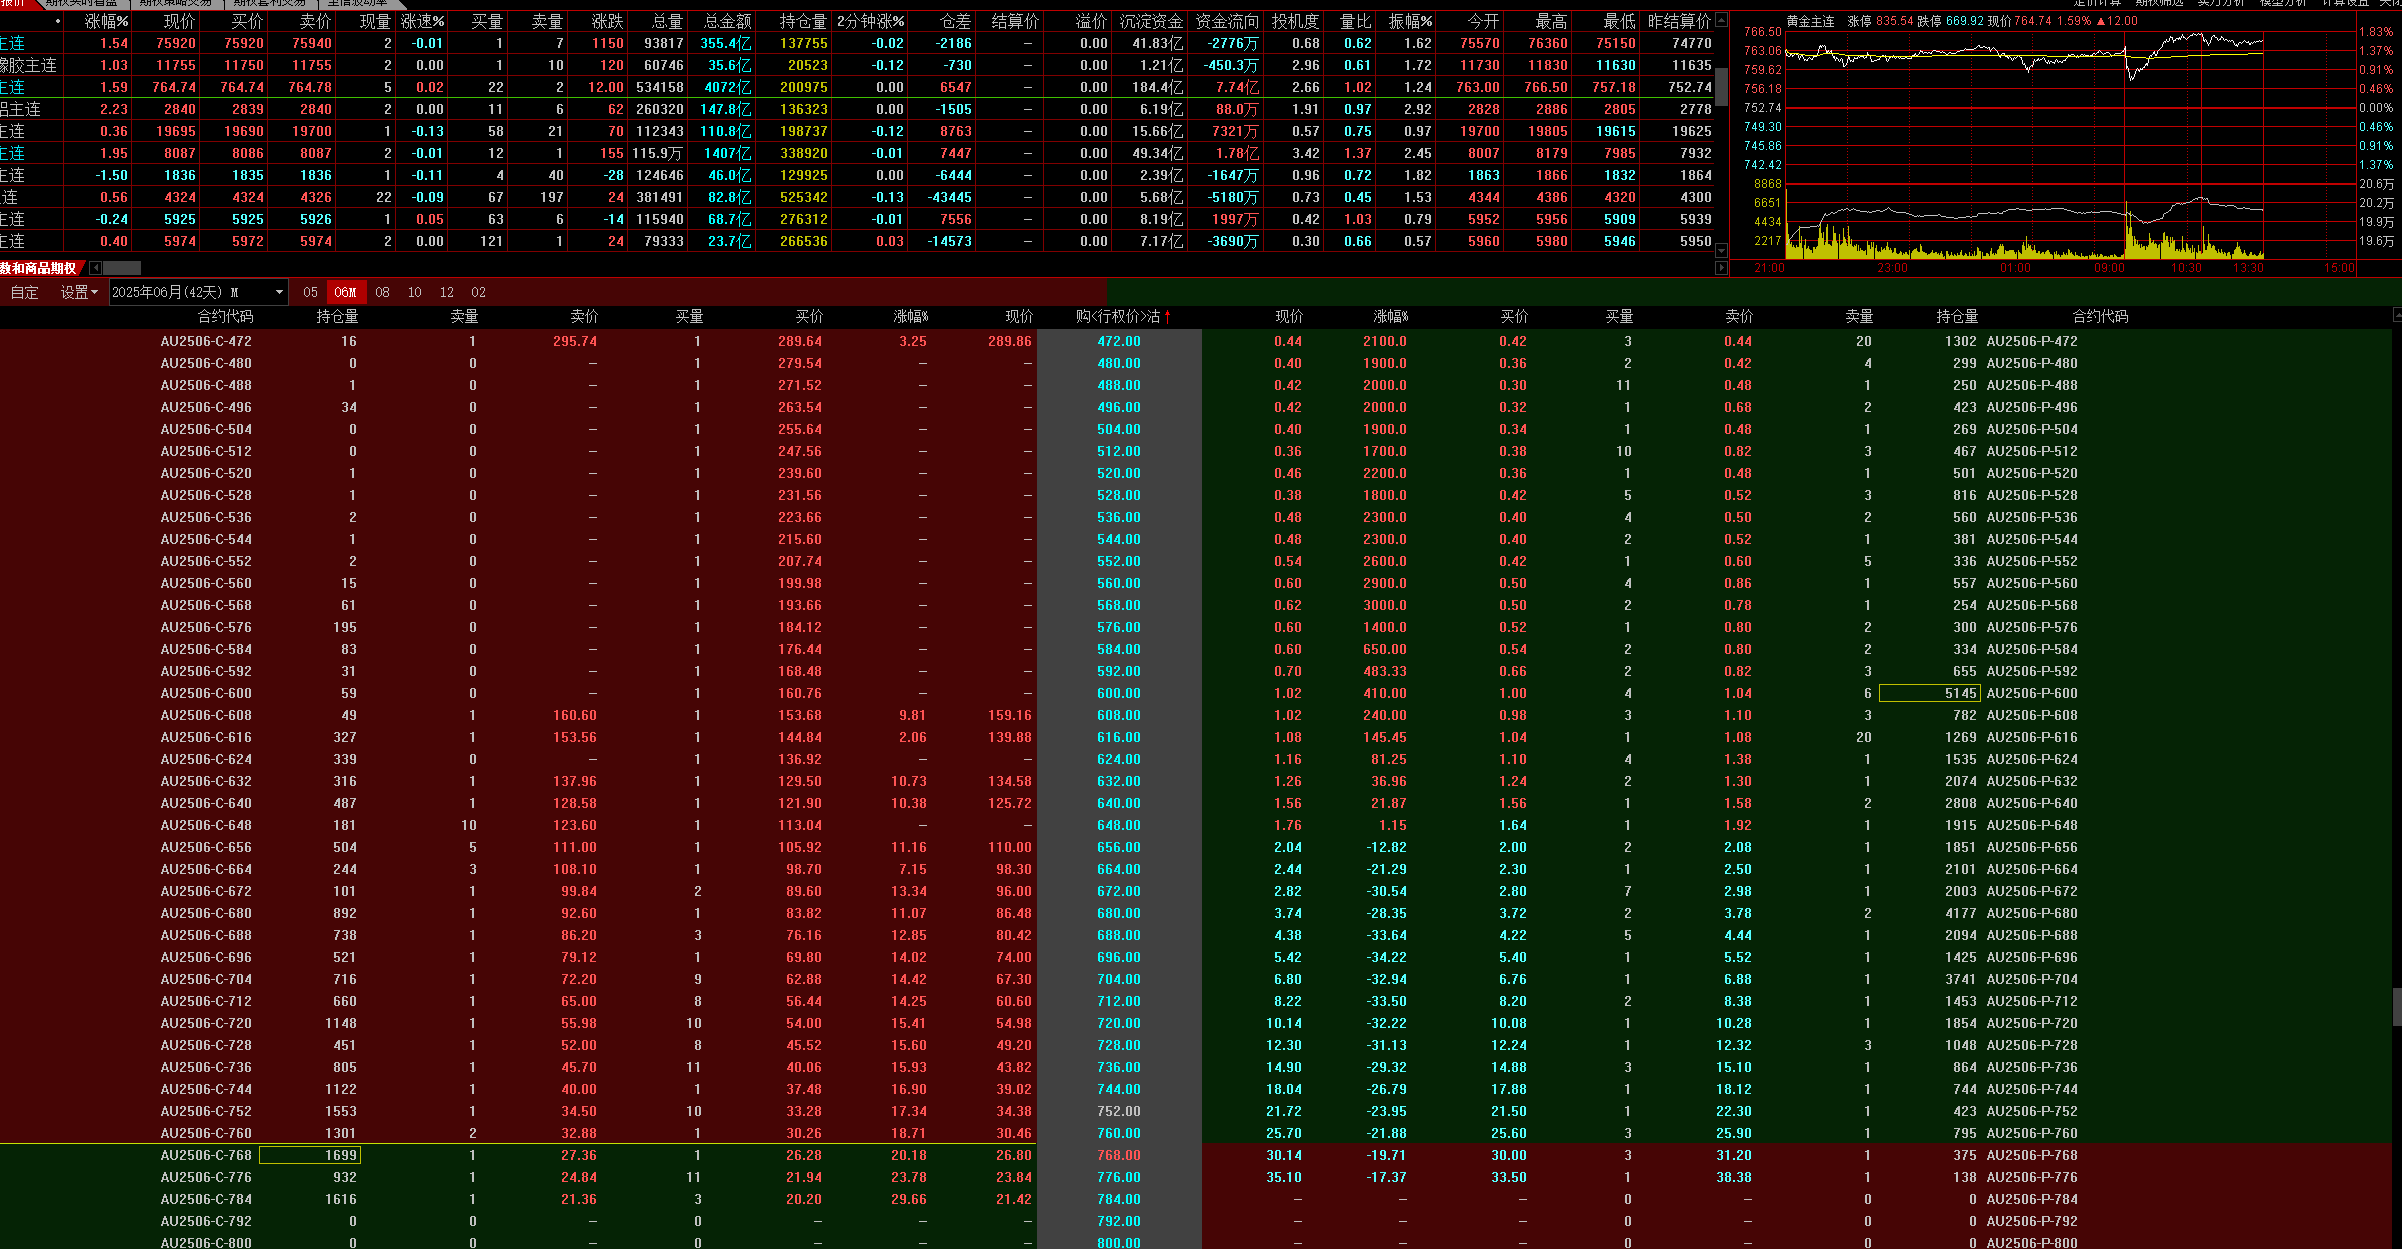
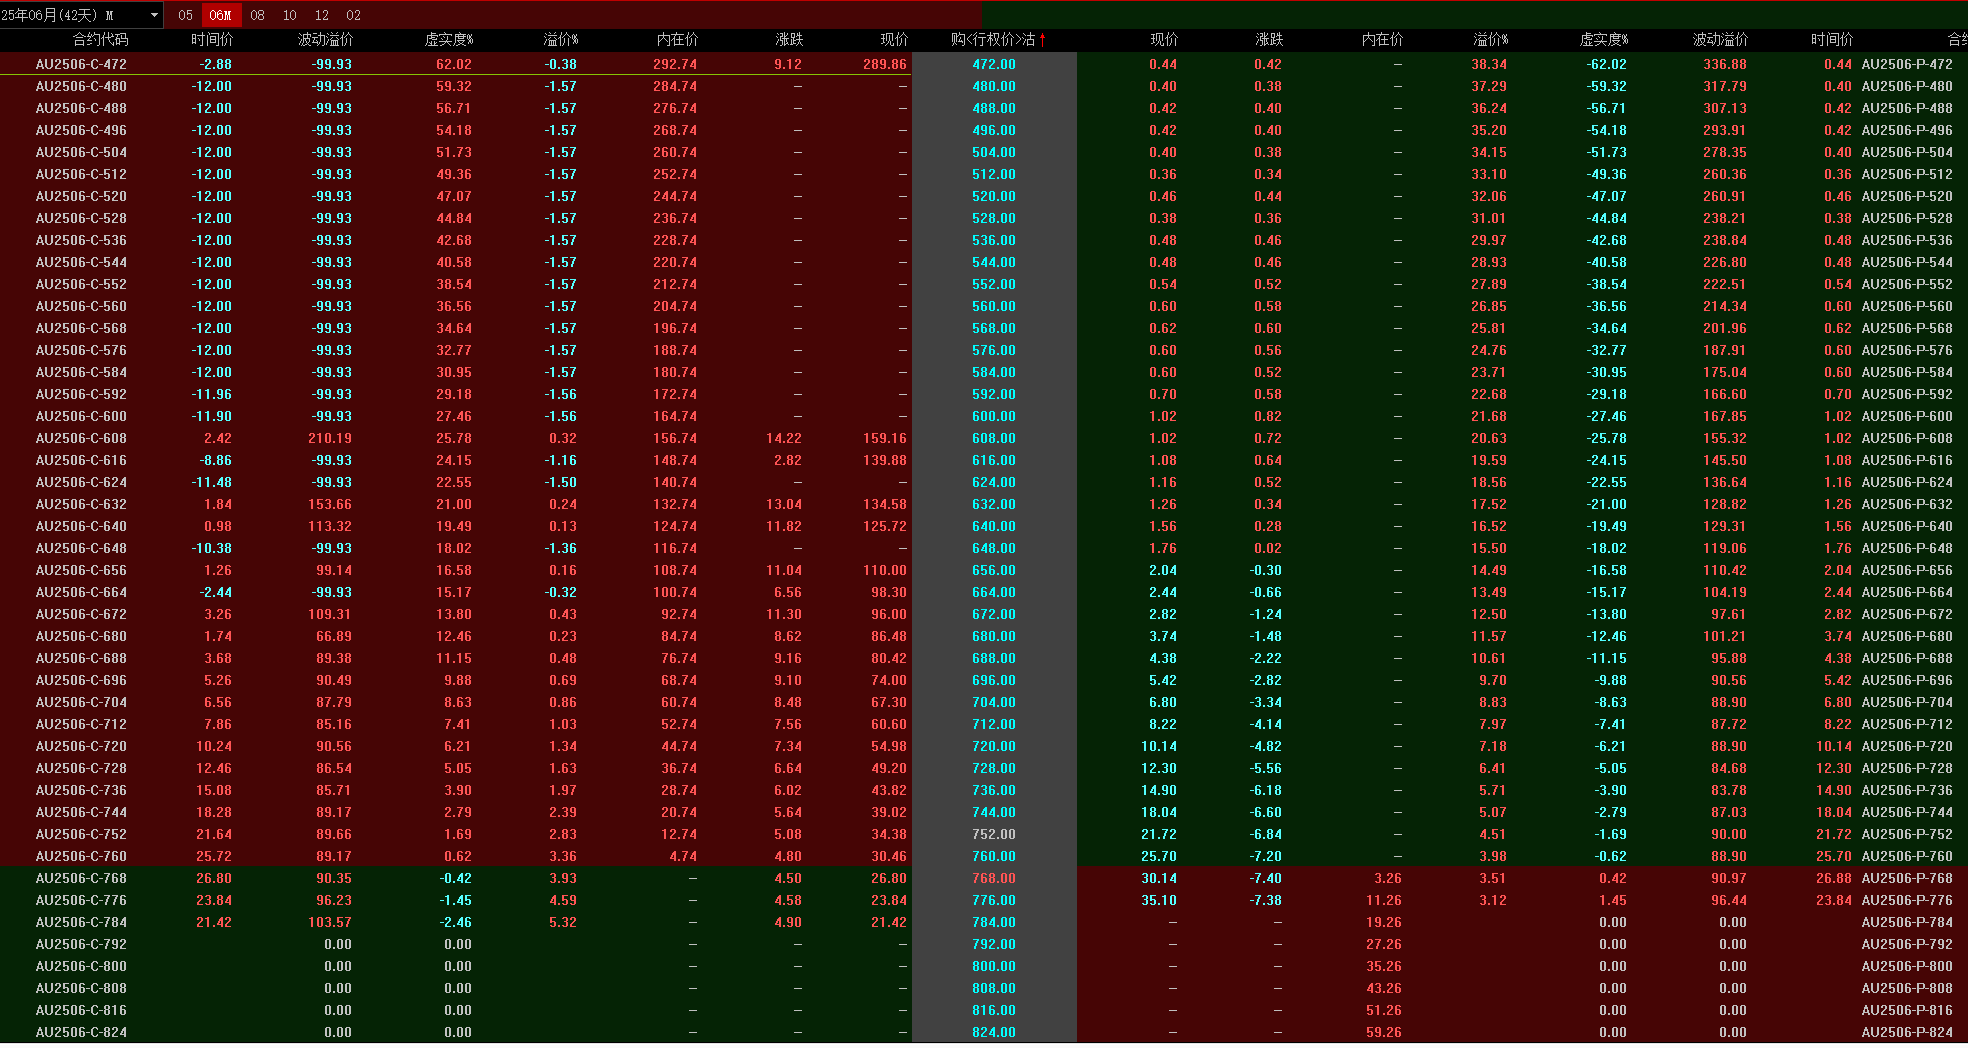
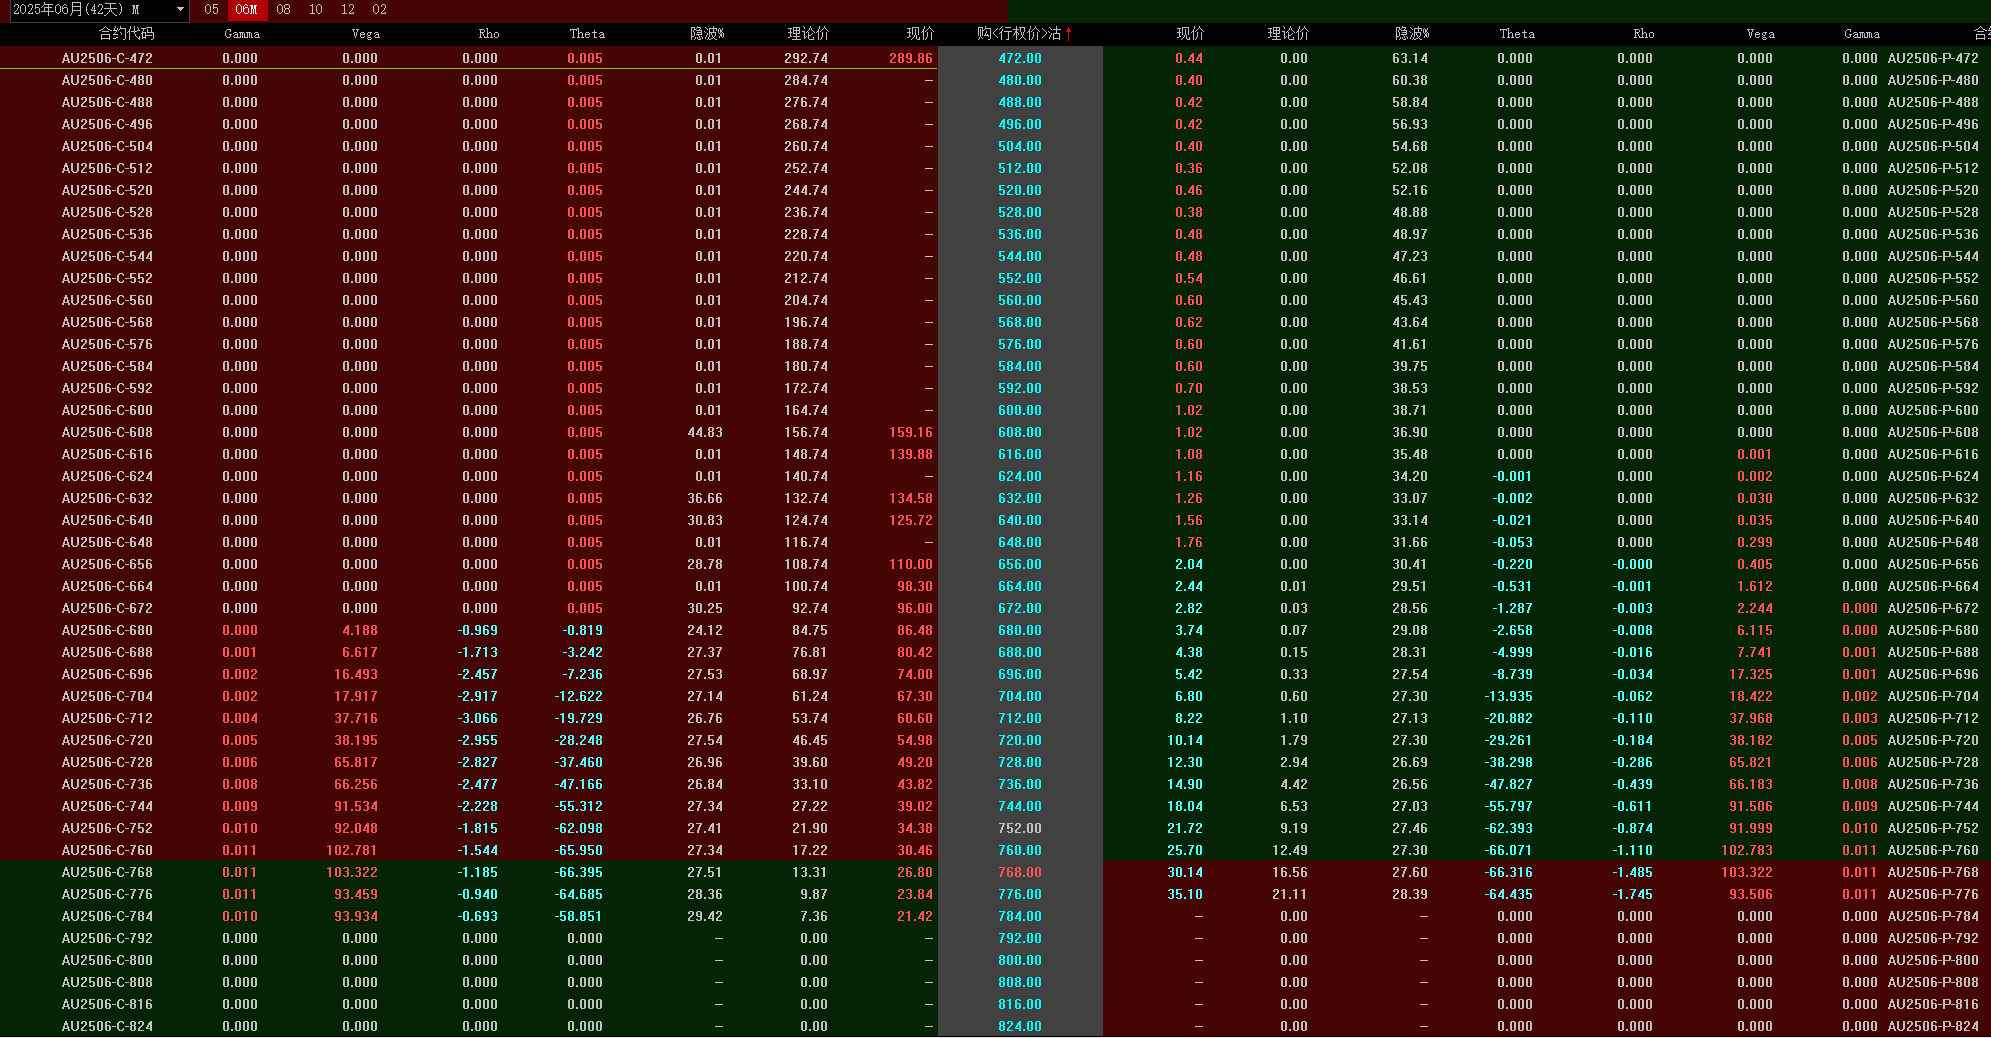
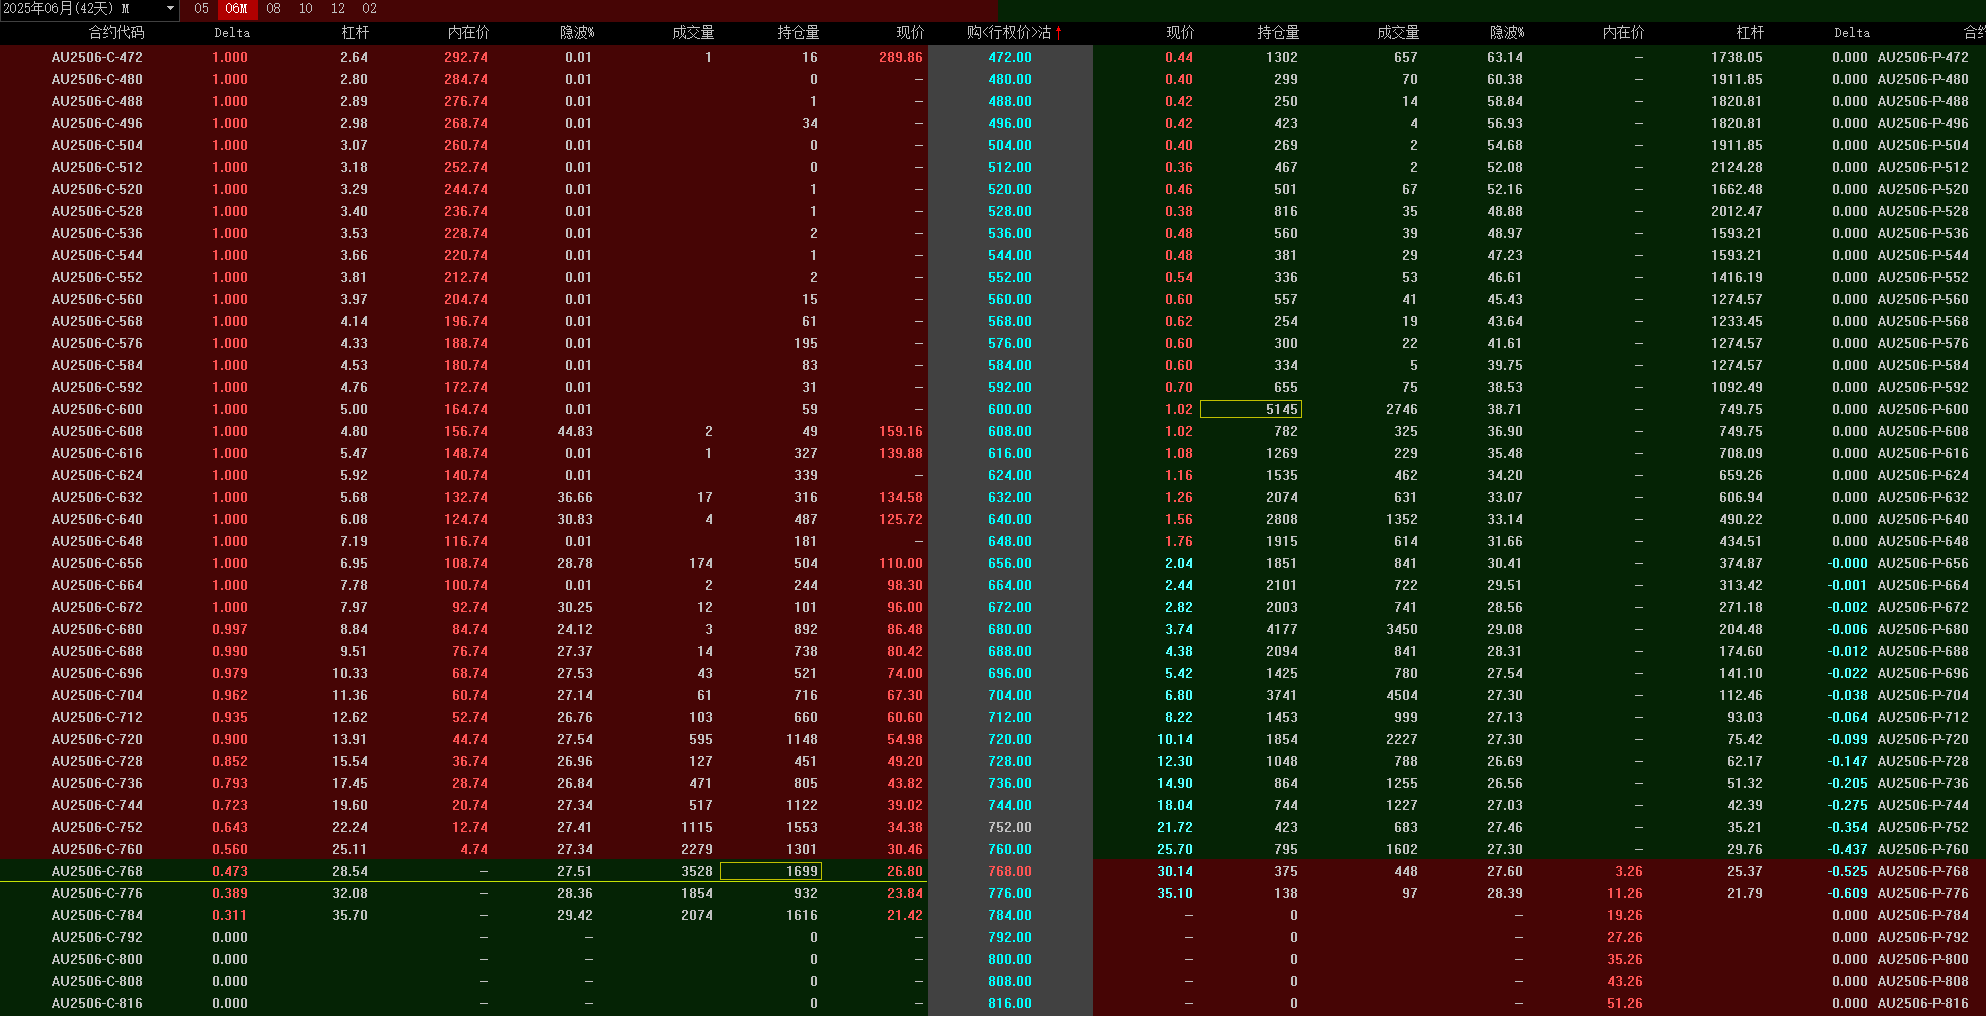
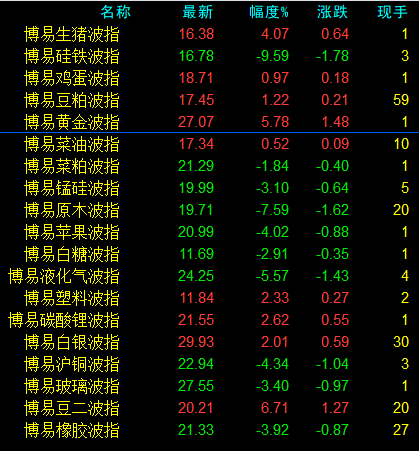
## Risk Free Rates
- 结算价  
无风险利率采用1年期定期存款基准利率；
## 计算方式
欧式期权采用BS理论，美式期权采用二叉树模型；   


# Explain The BS Formula
## $e^{-rT}$: Present Value Factor
Discount factor, it's used to discount a future value back to its present value, accounting for the time value of meney under a continuous compounding framework.
- continuous compounding   
`e` the base of natural logarithm, used in continuous compounding calculations.  
`r` annualized risk free interest.  
`T` time to expiry in years.   
`-rT` determines the rate of discounting.  
$e^{-rT}$ determines how much a future amount (strke price) is worth today.   
## Continous Compounding
$e^{rT}$ for growth and $e^{-rT}$ for discount.  
As opposed to at fixed intervals, it assumes that interest is compounded at every possible moment, leading to the use of the exponential function (e) in financial calculations.  
- Compounding   
means earning interest not only on the initial principal but also on accumulated interest over time.  
n in discrete become infinitely.    
## Discrete Compounding 
$Future Value = P*(1+\frac{r}{n})^{nT}$
P: initial principal ;   
$(1+\frac{1}{n})^{n}=e$ when n=infinite
## [e](https://en.wikipedia.org/wiki/E_(mathematical_constant)) 
$$(1+\frac{1}{n})^{n}=e$$  
$$\sum^{无穷}_{n=0}{\frac{1}{n!}}=e$$
## [Compound Interest](https://en.wikipedia.org/wiki/Compound_interest) 
e means continous compounding when n is infinitely while rate = 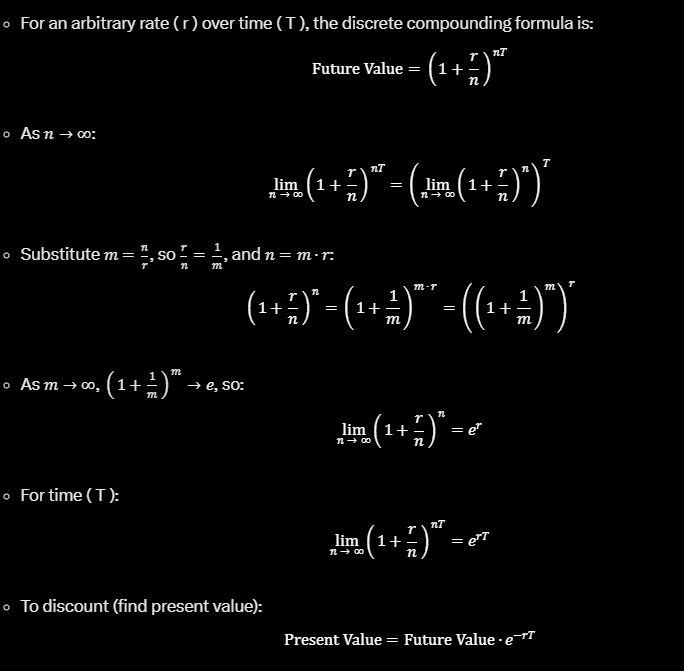


# 手动推导过程
$$
C = N(d_1)S_t - N(d_2)Ke^{-rT}
$$
where $d_1 = \frac{ln(\frac{S_t}{K}) + (r+\frac{σ^2}{2})t}{σ\sqrt{t}}$   
and $d_2 = d_1 - σ*\sqrt{t}$ 

`σ` is the output of BS, one standard deviation annual which out context around iv, high iv allows us to move very far from the stock pricw while still covering a 1SD range;    
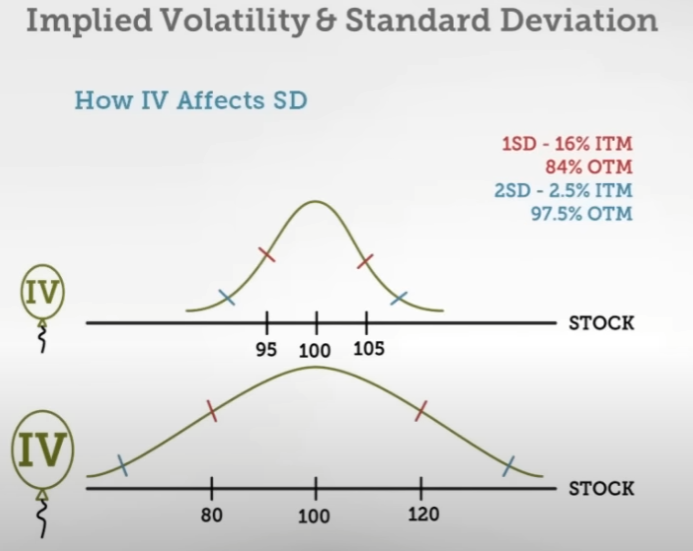

The payoff at expiration is $max(S_T - K, 0)$, the option price involves calculating the probability that $S_T > K$.  
`d1` measure how far the option is ITM, adjusted for the expected growth of the asset price and volatility.   
`d2` is related to the probability that the option will be exercised.







































# Concepts 
##### BSM assuming the underlying asset price follows a geometric Brownian motion.



In [38]:
from pydantic import BaseModel, PositiveFloat, NonNegativeFloat
from datetime import date
from enum import Enum 
from typing import Optional
import math
from scipy.stats import norm

# Define Option Type
class OptionType(str, Enum):
    CALL = "call"
    PUT = "put"
# Define Option Price
class OptionPrice(BaseModel):
    underlying_price: PositiveFloat
    strike_price: PositiveFloat
    time_to_expiry: NonNegativeFloat # day
    volatility_implied: NonNegativeFloat
    volatility_historical: NonNegativeFloat
    risk_free_rate: float 
    option_type: OptionType
    option_price: NonNegativeFloat
    delta: float 
    gamma: NonNegativeFloat
    theta: float
    vega: NonNegativeFloat
    rho: float
    d1: Optional[float] = None
    d2: Optional[float] = None
    expiration_date: Optional[date] = None 
    class Config:
        use_enum_values = True
    def calculate_d1(self) -> float:
        """ 
        d1 = (ln(S / K) + (r + σ^2/2)T)/(σ* squrt(T))
        """
        d1 = (math.log(self.underlying_price / self.strike_price) 
         + (self.risk_free_rate + self.volatility_historical ** 2 / 2) * self.time_to_expiry
         ) / (self.volatility_historical * self.time_to_expiry ** 0.5)
        self.d1 = d1
        return d1
    def calculate_d2(self) -> float:
        d2 = self.calculate_d1() - self.volatility_historical * self.time_to_expiry ** 0.5
        self.d2 = d2
        return d2
    def _calculate_price_call(self) -> float:
        p = self.underlying_price * norm.cdf(self.d1, loc=0, scale=1) - self.strike_price * math.e ** (-1 * self.risk_free_rate * self.time_to_expiry) * norm.cdf(self.d2, loc=0, scale=1)
        self.option_price = p
        return p
    
    def _calculate_price_put(self) -> float:
        p = self.strike_price * math.e ** (-1 * self.risk_free_rate * self.time_to_expiry) * norm.cdf(self.d2 * -1, loc=0, scale=1) - self.underlying_price * norm.cdf(self.d1 * -1, loc=0, scale=1)
        self.option_price = p
        return p

    def calculate_price(self) -> float:
        if not self.d1:
            self.calculate_d1()
        if not self.d2:
            self.calculate_d2()
        if self.option_type == OptionType.CALL:
            p = self._calculate_price_call()
        else:
            p = self._calculate_price_put()
        return p
        

In [1]:
# Create a Instance on Gold
risk_free_rate = 0.011
au2506c712_data = {
    "underlying_price": 764.74,
    "strike_price": 712,
    "time_to_expiry": 42 / 365,
    "volatility_implied": 0.2676, # IV
    "volatility_historical": 0.27, # ?
    "risk_free_rate": risk_free_rate,
    "option_type": "call",
    "option_price": 60.6,
    "delta": 0.935,
    "gamma": 0.004,
    "theta": -19.729,
    "vega": 37.716,
    "rho": -3.066,
    "expiration_date": date(2025, 6, 29)
}
au2506c768_data = {
    "underlying_price": 764.74,
    "strike_price": 768,
    "time_to_expiry": 42 / 365, # 42
    "volatility_implied": 0.2751, # IV
    "volatility_historical": 0.27, # ?
    "risk_free_rate": risk_free_rate,
    "option_type": "call",
    "option_price": 26.8,
    "delta": 0.473,
    "gamma": 0.011,
    "theta": -66.395,
    "vega": 103.322,
    "rho": -1.185,
    "expiration_date": date(2025, 6, 29)
}
example_call = {
    "underlying_price": 42,
    "strike_price": 40,
    "time_to_expiry": 0.5, # 42
    "volatility_implied": 0.2751, # IV
    "volatility_historical": 0.2, # ?
    "risk_free_rate": risk_free_rate,
    "option_type": "call",
    "option_price": 26.8,
    "delta": 0.473,
    "gamma": 0.011,
    "theta": -66.395,
    "vega": 103.322,
    "rho": -1.185,
    "expiration_date": date(2025, 6, 29)
}
op_call = OptionPrice(**example_call)
example_put = example_call.copy()
example_put.update({"option_type": "put"})
op_put = OptionPrice(**example_put)
# print(f"put: {op_call.model_dump()}")
# print(f"call: {op_put.model_dump()}")
op_call.calculate_price()
op_put.calculate_price()
print(f"op_call.option_price: {op_call.option_price}")
print(f"op_put.option_price: {op_put.option_price}")

KeyboardInterrupt: 


# Refs
[Black-Scholes Model](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model)    
[Black Scholes Option Pricing Model Explained In Excel](https://www.youtube.com/watch?v=J6OySvT-PDE)   
[py_vollib](https://github.com/vollib/py_vollib)   
[BS by Hand Example](https://www.youtube.com/watch?v=1eg_0hZ6M1I)   
[Khan Academy](https://www.khanacademy.org/economics-finance-domain/core-finance/derivative-securities/black-scholes/v/introduction-to-the-black-scholes-formula)   
[Finding the Solution to the BS Equation](https://digitalcommons.liu.edu/cgi/viewcontent.cgi?article=1074&context=post_honors_theses)   
[Matlab Example](https://www.mathworks.com/help/symbolic/the-black-scholes-formula-for-call-option-price.html)   
[Implied Volatility & Standard Deviation Explained](https://www.youtube.com/watch?v=StEHQgvVoto)      
[Stochastic Calculus for Quants | Understanding Geometric Brownian Motion using Itô Calculus](https://www.youtube.com/watch?v=Devm4ElEhGc)    
[Simulating Geometric Brownian Motion in Python | Stochastic Calculus for Quants](https://www.youtube.com/watch?v=jejjUPfaIXY)   
[Solving Geometric Brownian Motion](https://www.youtube.com/watch?v=y0s2GXREymI)    
[2006 by Karl Sigman Geometric Brownian motion](https://www.columbia.edu/~ks20/FE-Notes/4700-07-Notes-GBM.pdf)   
[pyOptionPricing](https://github.com/ikeepo/pyOptionPricing)   